In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
df = pd.read_csv("/kaggle/input/image-metadata/Metadata1.csv")
df = df.fillna('')

In [2]:
df['cleaned_text'] = df.apply(lambda row: ' '.join([row['description'], row['title'], row['user_tag_to_str']]), axis=1)
data = df[['cleaned_text','label']]

In [5]:

label_mapping = {'No Flooding': 0, 'Flooding': 1}
data['label'] = data['label'].map(label_mapping)
data

/tmp/ipykernel_34/1878633380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].map(label_mapping)


,cleaned_text,label,input_ids,attention_mask,labels
0,biltmore estate 2009 road trip obrero road trip,0,"[101, 12170, 7096, 5974, 3776, 2268, 2346, 444...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",No Flooding
1,chand minar daulatabad daulatabad fort ellora...,0,"[101, 9212, 2094, 19808, 2099, 4830, 18060, 90...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",No Flooding
2,"after the flood, the boarded up stores bear up...",0,"[101, 2044, 1996, 7186, 1010, 1996, 17383, 203...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",No Flooding
3,dscf6487 cork enchente flood ireland irlanda,0,"[101, 16233, 2278, 2546, 21084, 2620, 2581, 85...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",No Flooding
4,oconoe river - flooded athens georgia brown c...,0,"[101, 1051, 8663, 8913, 2314, 1011, 10361, 757...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",No Flooding
...,...,...,...,...,...
5275,90 550d camino canon canoneos550d canoneoskis...,0,"[101, 3938, 13274, 2094, 11503, 5740, 9330, 93...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",No Flooding
5276,"albany's corning preserve, day after irene al...",1,"[101, 10283, 1005, 1055, 9781, 2075, 7969, 101...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Flooding
5277,img_4989 al the waters in pike road,0,"[101, 10047, 2290, 1035, 4749, 2620, 2683, 263...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",No Flooding
5278,2013 fair flood img_3011 2013 county fair floo...,0,"[101, 2286, 4189, 7186, 10047, 2290, 1035, 191...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",No Flooding


In [6]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset

# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

# Load your dataset


# Ensure your dataset has the required columns
assert 'cleaned_text' in data.columns and 'label' in data.columns, "Dataset must have 'cleaned_text' and 'label' columns"

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize_function(text):
    return tokenizer(text, padding="max_length", truncation=True, return_tensors='pt')

# Apply tokenization to each text in the dataset
tokenized_texts = data['cleaned_text'].apply(lambda x: tokenize_function(x))

# Extract input_ids and attention_mask from tokenized texts and convert them to list of tensors
data['input_ids'] = tokenized_texts.apply(lambda x: x['input_ids'].squeeze(0))
data['attention_mask'] = tokenized_texts.apply(lambda x: x['attention_mask'].squeeze(0))
data['labels'] = data['label']

# Ensure all columns are in the correct format
data['input_ids'] = data['input_ids'].apply(lambda x: x.tolist())
data['attention_mask'] = data['attention_mask'].apply(lambda x: x.tolist())
data['labels'] = data['labels'].astype(int)

# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.input_ids = torch.tensor(data['input_ids'].tolist(), dtype=torch.long)
        self.attention_mask = torch.tensor(data['attention_mask'].tolist(), dtype=torch.long)
        self.labels = torch.tensor(data['labels'].tolist(), dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Split the dataset into training and test sets
train_size = int(0.8 * len(data))
train_data = data[:train_size].reset_index(drop=True)
test_data = data[train_size:].reset_index(drop=True)

train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

# Load the pre-trained model and move it to the GPU
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(data['labels'].unique())).to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",  # Ensure saving strategy matches evaluation strategy
    load_best_model_at_end=True,
    report_to='none',  # This avoids logging to remote services, feel free to change
    save_total_limit=1  # Limits the total number of checkpoints
)

# Define a Trainer class that handles the data transfer to GPU
class GPUTrainer(Trainer):
    def _prepare_inputs(self, inputs):
        return {k: v.to(self.args.device) for k, v in inputs.items()}

# Train the model
trainer = GPUTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

# Evaluate the model
trainer.evaluate()


Using device: cuda


/tmp/ipykernel_34/3236625760.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['input_ids'] = tokenized_texts.apply(lambda x: x['input_ids'].squeeze(0))
/tmp/ipykernel_34/3236625760.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['attention_mask'] = tokenized_texts.apply(lambda x: x['attention_mask'].squeeze(0))
/tmp/ipykernel_34/3236625760.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.320400,0.260677
2,0.259200,0.305647
3,0.136600,0.358904


{'eval_loss': 0.260677307844162,
 'eval_runtime': 17.5985,
 'eval_samples_per_second': 60.005,
 'eval_steps_per_second': 7.501,
 'epoch': 3.0}

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       668
           1       0.77      0.96      0.86       388

    accuracy                           0.88      1056
   macro avg       0.87      0.90      0.88      1056
weighted avg       0.90      0.88      0.88      1056



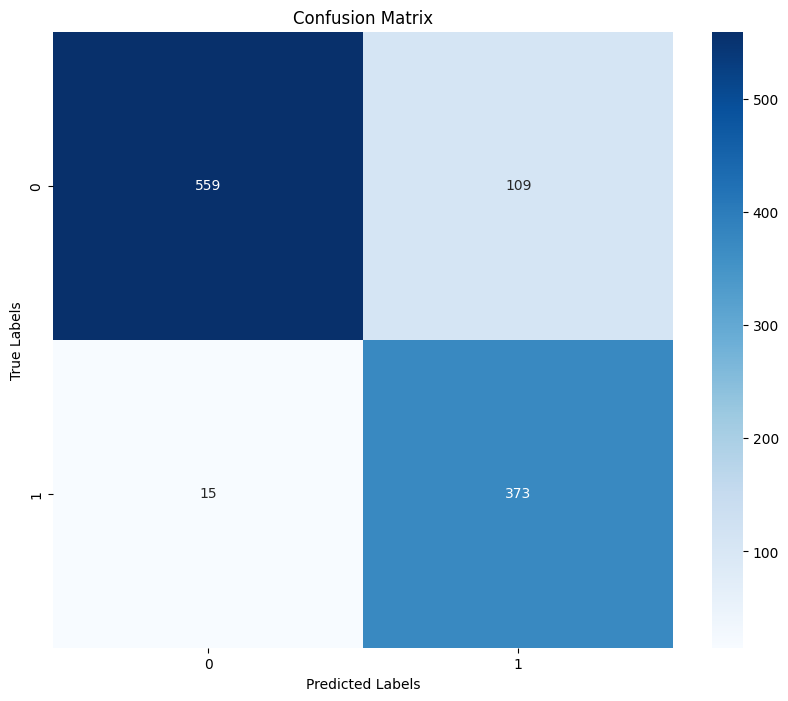

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
predictions = trainer.predict(test_dataset)

# Get the predicted labels
pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1).tolist()

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_data['labels'], pred_labels)

# Print classification report
print(classification_report(test_data['labels'], pred_labels))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
